# Installation

!git clone https://github.com/Near32/ReferentialGym.git ; cd ReferentialGym; git checkout develop; git pull; git status; pip install -e . 

In [1]:
import ReferentialGym

During importation of MineRLDataset:No module named 'minerl'
Please install minerl if you want to use the MineRLDataset.


# Datasets

Eventhough the ReferentialGym framework is able to accomodate any dataset that uses the PyTorch dataset interface (see this [list](https://pytorch.org/docs/stable/torchvision/datasets.html) for some examples provided by PyTorch), some datasets are more interesting than others to study **language emergence and grounding**.

In this section, we detail the different visual datasets that are available out-of-the-box with the ReferentialGym framework and that propose an interesting challenge for language emergence.

## 3DShapes (PyBullet):

In the paper [Compositional Obverter Communication Learning From Raw Visual Input](https://arxiv.org/abs/1804.02341), we are introduced to a dataset of 3D shapes that are procedurally generated from the following list of latent factors of variations:

1. Color: (blue, red, white, gray, yellow, green, cyan, magenta) (8 values)
2. Shapes: (box, sphere, cylinder, capsule, ellipsoid) (5 values)
3. (Implicit) Viewpoint: randomly sampled at each sample generation (i.e. samples (blue, box, viewpoint 1) and (red, box, viewpoint 1) **do not necessarily show a red/blue box under the same 3D viewpoint**, in spite of the indexing) - 100 random values per (color,shape) tuple. 

While the original dataset was not open-sourced (nor was the paper's code, but a replication can be found [here](https://github.com/benbogin/obverter)), the framework provides a replication of it using the [PyBulet](https://pybullet.org/wordpress/) library, and making the observation viewpoint no longer sampled randomly each time a new visual sample is made, but rather sampling randomly a set of values only once, resulting in the following list of (explicit) latent factors of variations:

1. Color: (Black, Red, Blue, Green, Brown, Purple, Light Gray, Light Green, Light Blue, Cyan, Orange, Yellow, Tan, Pink, Dark Gray) (at most 15 values)
2. Shapes: (cylinder, capsule, sphere, cube, torus, teddy, duck) (at most 7 values)
3. Viewpoint: randomly sampled upon dataset creation (i.e. samples with the same viewpoint index **do show the relevant objects under the very same 3D viewpoint**) - parameterizable (default=100) number of random samples.




### Building a dataset with 3 colors, 7 shapes, 2 viewpoints:
Make sure to install PyBullet:

In [ ]:
!pip install pybullet

Generate the dataset:

In [44]:
# Data augmentation:
stimulus_resize_dim = 64
normalize_rgb_values = False 
rgb_scaler = 1.0 #255.0
from ReferentialGym.datasets.utils import ResizeNormalize
transform = ResizeNormalize(
    size=stimulus_resize_dim, 
    normalize_rgb_values=normalize_rgb_values,
    rgb_scaler=rgb_scaler
)

img_size = 64
nb_shapes = 7
nb_colors = 3
nb_samples = 2
nb_train_colors = 2
shuffle_seed = '40'
train_test_split_strategy = f'compositional-{shuffle_seed}-nb_train_colors_{nb_train_colors}' 

root = './datasets/3DShapePyBullet-dataset'
root += f'imgS{img_size}-shapes{nb_shapes}-colors{nb_colors}-samples{nb_samples}'

train_dataset = ReferentialGym.datasets._3DShapesPyBulletDataset(
    root=root, 
    train=True, 
    transform=transform,
    generate=True,
    img_size=img_size,
    nb_shapes=nb_shapes,
    nb_colors=nb_colors,
    nb_samples=nb_samples,
    split_strategy=train_test_split_strategy,
)

test_dataset = ReferentialGym.datasets._3DShapesPyBulletDataset(
    root=root, 
    train=False, 
    transform=transform,
    generate=False,
    img_size=img_size,
    nb_shapes=nb_shapes,
    nb_colors=nb_colors,
    nb_samples=nb_samples,
    split_strategy=train_test_split_strategy,
)

building dataset...
saving datasets...
datasets saved at ./datasets/3DShapePyBullet-datasetimgS64-shapes7-colors3-samples2/3d_shapes_pybullet_dataset.pickle
Dataset Size: 28 out of 42: 66.66666666666667%.
Dataset loaded : OK.
Dataset Size: 14 out of 42: 33.333333333333336%.
Dataset loaded : OK.


In [6]:
train_dataset._generate_all()

 57%|█████▋    | 16/28 [00:00<00:00, 153.25it/s]

saving datasets...
Datasets saved at ./datasets/3DShapePyBullet-datasetimgS64-shapes7-colors3-samples2/3d_shapes_pybullet_dataset.pickle


100%|██████████| 28/28 [00:19<00:00, 153.25it/s]

In [7]:
test_dataset._generate_all()


 79%|███████▊  | 11/14 [00:00<00:00, 102.04it/s]

saving datasets...
Datasets saved at ./datasets/3DShapePyBullet-datasetimgS64-shapes7-colors3-samples2/3d_shapes_pybullet_dataset.pickle



100%|██████████| 14/14 [00:14<00:00, 102.04it/s]

The generated dataset looks as follows:

In [14]:
import torch
import torchvision

train_images = torch.stack([torch.from_numpy(t) for t in train_dataset.imgs.values()], axis=0)
print(train_images.shape)
train_grid = torchvision.utils.make_grid(train_images)


torch.Size([28, 3, 64, 64])


In [36]:
test_images = torch.stack([torch.from_numpy(t) for t in test_dataset.imgs.values()], axis=0)
print(test_images.shape)
test_grid = torchvision.utils.make_grid(test_images)

torch.Size([14, 3, 64, 64])


In [40]:
print(train_grid.shape, test_grid.shape)
train_test_grids = torch.cat([train_grid, test_grid], axis=1)

torch.Size([3, 266, 530]) torch.Size([3, 134, 530])


In [31]:
import matplotlib.pyplot as plt
import numpy as np 
import cv2

def plot(img, resize_scaler=None):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (2, 1, 0))
    if resize_scaler is not None:
        #width = int(img.shape[1] * scale_percent / 100)
        #height = int(img.shape[0] * scale_percent / 100)
        #dim = (width, height)
        newsize = (resize_scaler*npimg.shape[1], resize_scaler*npimg.shape[0])
        print(newsize)
        npimg = cv2.resize(npimg, newsize, interpolation=cv2.INTER_CUBIC)

    plt.imshow(npimg)

(4000, 5300)


<IPython.core.display.Javascript object>


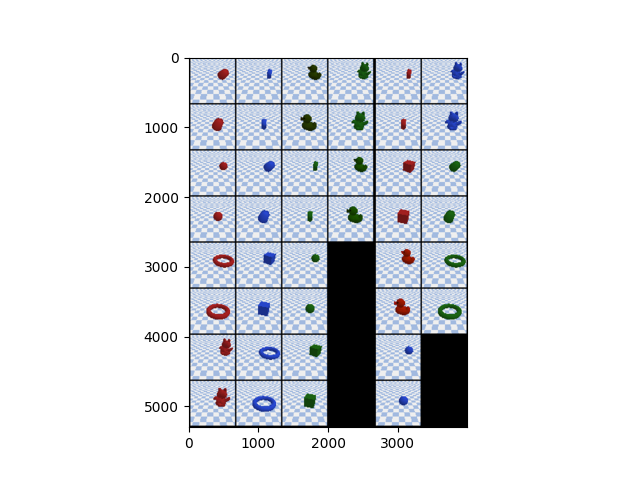

In [43]:
%matplotlib notebook
plot(train_test_grids, resize_scaler=10)

Note that the `train_test_split_strategy` used here aims to test for **zero-shot compositionality**, as presented in section 3.3 of the original paper. 

---

---

## Other relevant dataset: dSprites
The [dSprites dataset](https://github.com/deepmind/dsprites-dataset) drove extensive research on the disentanglement properties of learned representations, especially with unsupervised learning methods. It consits of 2D shapes procedurally generated some latent factors of variations:

1. Color: white
2. Shape: square, ellipse, heart
3. Scale: 6 values linearly spaced in [0.5, 1]
4. Orientation: 40 values in [0, 2 pi]
5. Position X: 32 values in [0, 1]
6. Position Y: 32 values in [0, 1]

![GIF of the dataset](https://github.com/deepmind/dsprites-dataset/raw/master/dsprites.gif)

In the above GIF, we can see that there are some visual representations whose latent encodings may be different from each other but remain visually undistinguishable. For instance, the white ellipses with orientations of either 0 or pi are visually indistinguishable, similarly for the square with orientations 0, pi/2, pi, 3 pi/2...
Therefore, in order to use the dSprites dataset for language emergence, it is important to either restrict the set of valid values on the orientation latent factor, or to constrain oneself to the use of heart shape solely.

Any of the later can be done using the ReferentialGym framework via the `train_test_split_strategy` argument.
For instance, the value `combinatorial2-Y-4-2-X-4-2-Orientation-40-N-Scale-6-N-Shape-3-N` restricts as follows:

1. Color: white
2. Shape: at training time: heart (index(/divider)=3, from the ordered list) / at test time: "N"o difference.
3. Scale: at training time: taking 1 value every 6 (divider=6), i.e. only 1 value used out of the 6 possible values / at test time: "N"o difference.
4. Orientation: at training time: taking 1 value every 40 (divider=40), i.e. only 1 value used out of the 40 possible values / at test time: "N"o difference.
5. Position X: at training time: taking 1 value every 4 (divider=4), i.e. only 8 values used out of the 32 possible values / at test time: taking 1 value every 2 (divider=2) out of the training set, and marking those values as testing-purpose values.
6. Position Y: at training time: taking 1 value every 4 (divider=4), i.e. only 8 values used out of the 32 possible values / at test time: taking 1 value every 2 (divider=2) out of the training set, and marking those values as testing-purpose values. 

Finally, `combinatorial2` implies that samples whose latent factor representation contains "2" or more testing-purpose values will be held out from the training dataset and made a member of the testing dataset. For more details, please refer to this [zoo folder](https://github.com/Near32/ReferentialGym/tree/master/zoo/referential-games%2Bst-gs).

---

### Reproduciability: seed and cudnn benchmark

In [48]:
import torch
import numpy as np
import random 

seed = 10
fast = False 

# Following: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(seed)
if hasattr(torch.backends, "cudnn") and not(fast):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

np.random.seed(seed)
random.seed(seed)

---

# Create a Referential Game with ReferentialGym:

The framework provides a common implementation for many features and constraints of the main referential game variants that can be found in the surveyed literature to date, thus allowing for a
more systematic comparison between approaches. The following paper details a nomenclature relevant to the current framework as well as the philosophy behind it:

> [ReferentialGym: A Nomenclature and Framework for Language Emergence & Grounding in (Visual) Referential Games](https://arxiv.org/abs/2012.09486) (or [workshop link 2](https://drive.google.com/file/d/1p6rgNcvtug7UuVHrEgDIZNI6nYILkqZR/view?usp=sharing))
> Kevin Denamganaï and James Alfred Walker.
> [4th NeurIPS Workshop on Emergent Communication: "Talking with Strangers: Zero-Shot Emergent Communication", 2020](https://sites.google.com/view/emecom2020).

In the following section, the instantiation of a descriptive, object-centric, partial-observability, discriminative referential game will be detailed:

In [61]:
import ReferentialGym as rg

nbr_train_distractors = 4
nbr_test_distractors = 4

distractor_sampling = "uniform"

descriptive_game = True
descriptive_ratio = 1-(1/(nbr_train_distractors+2))

object_centric = True 

batch_size = 32 

dataloader_num_worker = 4
stimulus_resize_dim = 32

use_cuda = True

rg_config = {
    "observability":            "partial",
    "nbr_communication_round":  1,
    "nbr_distractors":          {"train":nbr_train_distractors, "test":nbr_test_distractors},
    "distractor_sampling":      distractor_sampling,
    
    "descriptive":              descriptive_game,
    "descriptive_target_ratio": descriptive_ratio,

    "object_centric":           object_centric,
    "nbr_stimulus":             1, #static images, not video...

    "batch_size":               batch_size,
    "dataloader_num_worker":    dataloader_num_worker,
    "stimulus_depth_dim":       3,
    "stimulus_resize_dim":      stimulus_resize_dim, 

    "learning_rate":            1e-4,
    "adam_eps":                 1e-8,
    "dropout_prob":             0.0,
    "embedding_dropout_prob":   0.0,

    "with_gradient_clip":       False,
    "gradient_clip":            1e0,

    "use_homoscedastic_multitasks_loss": False,
    "use_feat_converter":       False,

    "use_curriculum_nbr_distractors": False,
    "curriculum_distractors_window_size": 25, #100,

    "nbr_experience_repetition":  1,

    "with_utterance_penalization":  False,
    "with_utterance_promotion":     False,
    "utterance_oov_prob":  0.0,  
    # Expected penalty of observing out-of-vocabulary words. 
    # The greater this value, the greater the loss/cost.
    "utterance_factor":    1e-2,

    "with_speaker_entropy_regularization":  False,
    "with_listener_entropy_regularization":  False,
    "entropy_regularization_factor":    -1e-2,

    "with_mdl_principle":       False,
    "mdl_principle_factor":     5e-2,

    "with_weight_maxl1_loss":   False,

    "use_cuda":                 use_cuda,

    "train_transform":            transform,
    "test_transform":             transform,
    }


In [62]:
## Logger:
from ReferentialGym.utils import statsLogger
save_path = "./tutorial/"
logger = statsLogger(path=save_path, dumpPeriod=100)

### Communication Channel: 

We will focus on a communication channel parameterized with the [Straight-Through](https://arxiv.org/abs/1705.11192) [Gumbel-Softmax](https://arxiv.org/abs/1611.01144) approach, with a maximum sentence length `L=5` and a vocabulary size `V=20`:

In [63]:
vocab_size = 20
max_sentence_length = 5

graphtype = "straight_through_gumbel_softmax"

comm_ch_config = {
    "graphtype":                graphtype,
    "tau0":                     0.2,
    "gumbel_softmax_eps":       1e-6,
    "vocab_size":               vocab_size,
    "max_sentence_length":      max_sentence_length,
    "force_eos":                False,
    
}

rg_config.update(comm_ch_config)

---

### Agent architecture:

In [73]:
agent_arch = "BN-CNN" # with batch normalization layers in the CNN, otherwise "CNN".
agent_loss_type = "Hinge" #"NLL"

agent_config = {
    "symbol_embedding_size":    64,

    "agent_architecture":       agent_arch,
    "agent_learning":           "learning",  #"transfer_learning" : CNN"s outputs are detached from the graph...
    "agent_loss_type":          agent_loss_type,

}

rg_config.update(agent_config)
agent_config.update(rg_config)
agent_config["architecture"] = agent_config["agent_architecture"]

print(agent_config)

{'symbol_embedding_size': 64, 'agent_architecture': 'BN-CNN', 'agent_learning': 'learning', 'agent_loss_type': 'Hinge', 'observability': 'partial', 'nbr_communication_round': 1, 'nbr_distractors': {'train': 4, 'test': 4}, 'distractor_sampling': 'uniform', 'descriptive': True, 'descriptive_target_ratio': 0.8333333333333334, 'object_centric': True, 'nbr_stimulus': 1, 'batch_size': 32, 'dataloader_num_worker': 4, 'stimulus_depth_dim': 3, 'stimulus_resize_dim': 32, 'learning_rate': 0.0001, 'adam_eps': 1e-08, 'dropout_prob': 0.0, 'embedding_dropout_prob': 0.0, 'with_gradient_clip': False, 'gradient_clip': 1.0, 'use_homoscedastic_multitasks_loss': False, 'use_feat_converter': False, 'use_curriculum_nbr_distractors': False, 'curriculum_distractors_window_size': 25, 'nbr_experience_repetition': 1, 'with_utterance_penalization': False, 'with_utterance_promotion': False, 'utterance_oov_prob': 0.0, 'utterance_factor': 0.01, 'with_speaker_entropy_regularization': False, 'with_listener_entropy_regu

#### Speaker agent:

In [79]:
import copy 

symbol_processing_nbr_hidden_units = 64

speaker_config = copy.deepcopy(agent_config)

# Observability: if partial, then the speaker does not see any distractor.
if rg_config["observability"]== "partial":
    speaker_config["nbr_distractors"] = 0

speaker_config["use_feat_converter"] = False
# If True, then some FC layers are interweaved between 
# the cnn/encoder and the symbol_processing/language module
# in order to adapt the size of the features to the size of 
# the language module.

if "BN" in agent_arch:
    speaker_config["cnn_encoder_channels"] = ["BN32","BN32","BN32","BN32","BN32","BN32","BN32","BN32"]
else:
    speaker_config["cnn_encoder_channels"] = [32,32,32,32,32,32,32,32]

speaker_config["cnn_encoder_kernels"] = [3,3,3,3,3,3,3,3]
speaker_config["cnn_encoder_strides"] = [2,1,1,2,1,2,1,2]
speaker_config["cnn_encoder_paddings"] = [1,1,1,1,1,1,1,1]
speaker_config["cnn_encoder_non_linearities"] = [torch.nn.ReLU]
speaker_config["cnn_encoder_fc_hidden_units"] = [] #[128,] 
# the last FC layer is provided by the cnn_encoder_feature_dim parameter below...

speaker_config["cnn_encoder_feature_dim"] = 128 
# N.B.: if cnn_encoder_fc_hidden_units is [],
# then this last parameter does not matter.
# The cnn encoder is not topped by a FC network.

speaker_config["cnn_encoder_mini_batch_size"] = batch_size
speaker_config["feat_converter_output_size"] = symbol_processing_nbr_hidden_units

# The temporal encoder aims at encoding video-like inputs.
# Since we are using static images here, leaving its hyperparameters at 0 skips it.
speaker_config["temporal_encoder_nbr_hidden_units"] = 0
speaker_config["temporal_encoder_nbr_rnn_layers"] = 0
speaker_config["temporal_encoder_mini_batch_size"] = batch_size

speaker_config["symbol_processing_nbr_hidden_units"] = symbol_processing_nbr_hidden_units
speaker_config["symbol_processing_nbr_rnn_layers"] = 1


In [82]:
from ReferentialGym.agents import LSTMCNNSpeaker

batch_size = 4
speaker_nbr_distractors = speaker_config['nbr_distractors']
nbr_stimulus = rg_config['nbr_stimulus'] #static images, not video
obs_shape = [
    speaker_nbr_distractors+1,
    nbr_stimulus, 
    rg_config['stimulus_depth_dim'],
    rg_config['stimulus_resize_dim'],
    rg_config['stimulus_resize_dim']
]

speaker = LSTMCNNSpeaker(
    kwargs=speaker_config, 
    obs_shape=obs_shape, 
    vocab_size=vocab_size, 
    max_sentence_length=max_sentence_length,
    agent_id='s0',
    logger=logger
)

print(speaker)

Dim: 16
Dim: 16
Dim: 16
Dim: 8
Dim: 8
Dim: 4
Dim: 4
Dim: 2
LSTMCNNSpeaker(
  (cnn_encoder): ConvolutionalBody(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

#### Listener agent:

In [84]:
from ReferentialGym.agents import LSTMCNNListener

listener_config = copy.deepcopy(speaker_config)
listener_config['nbr_distractors'] = rg_config['nbr_distractors']['train']

listener_nbr_distractors = rg_config['nbr_distractors']["train"]
nbr_stimulus = listener_config['nbr_stimulus']
obs_shape = [
    listener_nbr_distractors+1,
    nbr_stimulus, 
    rg_config['stimulus_depth_dim'],
    rg_config['stimulus_resize_dim'],
    rg_config['stimulus_resize_dim']
]

listener = LSTMCNNListener(
  kwargs=listener_config, 
  obs_shape=obs_shape, 
  vocab_size=vocab_size, 
  max_sentence_length=max_sentence_length,
  agent_id='l0',
  logger=logger
)

print(listener)

Dim: 16
Dim: 16
Dim: 16
Dim: 8
Dim: 8
Dim: 4
Dim: 4
Dim: 2
LSTMCNNListener(
  (cnn_encoder): ConvolutionalBody(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1

---

## Referential Game Graph:

Now that we have build some agents, we need to define a handler for the population of agents (here only made up the listener and speaker that we have just built, but they could be used as blueprint for a population of agents as experimented with in [Cogswell et al.](https://arxiv.org/abs/1904.09067)) and the graph placeholders `current_speaker` and `current_listener` to have some referential game being played.

In [85]:
from ReferentialGym import modules as rg_modules

modules = {}

In [86]:
# Population Handler:
population_handler_id = "population_handler_0"
population_handler_config = copy.deepcopy(rg_config)
population_handler_config["verbose"] = False
population_handler_stream_ids = {
    "current_speaker_streams_dict":"modules:current_speaker",
    "current_listener_streams_dict":"modules:current_listener",
    "epoch":"signals:epoch",
    "mode":"signals:mode",
    "global_it_datasample":"signals:global_it_datasample",
}

# Current Speaker:
current_speaker_id = "current_speaker"

# Current Listener:
current_listener_id = "current_listener"

modules[population_handler_id] = rg_modules.build_PopulationHandlerModule(
    id=population_handler_id,
    prototype_speaker=speaker,
    prototype_listener=listener,
    config=population_handler_config,
    input_stream_ids=population_handler_stream_ids
)

modules[current_speaker_id] = rg_modules.CurrentAgentModule(id=current_speaker_id,role="speaker")
modules[current_listener_id] = rg_modules.CurrentAgentModule(id=current_listener_id,role="listener")

Create Agents: ...
Create Agents: OK.


Now that we have our population of agents and the relevant graph placeholders, i.e. all the modules where learning happens, we can add the final optimization module. Indeed, upon its creation, it parses all the other modules for learnable parameters:

In [88]:
optim_id = "global_optim"
optim_config = {
"modules":modules,
"learning_rate":rg_config["learning_rate"],
"optimizer_type":"adam",
"with_gradient_clip":rg_config["with_gradient_clip"],
"adam_eps":rg_config["adam_eps"],
}

optim_module = rg_modules.build_OptimizationModule(
id=optim_id,
config=optim_config,
)
modules[optim_id] = optim_module

### Metrics:
In order to probe the graph, we can include a few metrics and some loggers:
+ Topographic Similarity
+ Instantaneous Coordination (1-step Causal Influence in Communication)

In [91]:
"""
grad_recorder_id = "grad_recorder"
grad_recorder_module = rg_modules.build_GradRecorderModule(id=grad_recorder_id)
modules[grad_recorder_id] = grad_recorder_module
"""

topo_sim_metric_id = "topo_sim_metric"
topo_sim_metric_module = rg_modules.build_TopographicSimilarityMetricModule(
    id=topo_sim_metric_id,
    config = {
        "parallel_TS_computation_max_workers":16,
        "epoch_period": 2, #the metric is computed for 1 epoch every `epoch_period` epochs.
        "fast":False, #whether to compute an approximate metric or not, the approximate being fast.
        "verbose":False,
        "vocab_size":rg_config["vocab_size"],
    }
)
modules[topo_sim_metric_id] = topo_sim_metric_module

inst_coord_metric_id = "inst_coord_metric"
inst_coord_metric_module = rg_modules.build_InstantaneousCoordinationMetricModule(
    id=inst_coord_metric_id,
    config = {
        "epoch_period":1,
    }
)
modules[inst_coord_metric_id] = inst_coord_metric_module

"""
# Rather than a simple referential game accuracy metric,
# this later module computes an accuracy value for each
# latent factors in the dSprites dataset:
dsprites_latent_metric_id = "dsprites_latent_metric"
dsprites_latent_metric_module = rg_modules.build_dSpritesPerLatentAccuracyMetricModule(id=dsprites_latent_metric_id,
    config = {
      "epoch_period":1,
    }
)
modules[dsprites_latent_metric_id] = dsprites_latent_metric_module
"""

"""
# Evaluate the speaker's learned representation in terms of disentanglement:
# mainly useful when using a VAE-based architecture for the speaker's encoder:
speaker_factor_vae_disentanglement_metric_id = "speaker_factor_vae_disentanglement_metric"
speaker_factor_vae_disentanglement_metric_input_stream_ids = {
    "model":"modules:current_speaker:ref:ref_agent:cnn_encoder",
    "representations":"modules:current_speaker:ref:ref_agent:features",
    "experiences":"current_dataloader:sample:speaker_experiences", 
    "latent_representations":"current_dataloader:sample:speaker_exp_latents", 
    "latent_values_representations":"current_dataloader:sample:speaker_exp_latents_values",
    "indices":"current_dataloader:sample:speaker_indices", 
}
speaker_factor_vae_disentanglement_metric_module = rg_modules.build_FactorVAEDisentanglementMetricModule(
    id=speaker_factor_vae_disentanglement_metric_id,
    input_stream_ids=speaker_factor_vae_disentanglement_metric_input_stream_ids,
    config = {
      "epoch_period":args.metric_epoch_period,
      "batch_size":64,#5,
      "nbr_train_points":10000,#3000,
      "nbr_eval_points":5000,#2000,
      "resample":False,
      "threshold":5e-2,#0.0,#1.0,
      "random_state_seed":args.seed,
      "verbose":False,
      "active_factors_only":True,
    }
)
modules[speaker_factor_vae_disentanglement_metric_id] = speaker_factor_vae_disentanglement_metric_module
"""

"""
listener_factor_vae_disentanglement_metric_id = "listener_factor_vae_disentanglement_metric"
listener_factor_vae_disentanglement_metric_input_stream_ids = {
    "model":"modules:current_listener:ref:ref_agent:cnn_encoder",
    "representations":"modules:current_listener:ref:ref_agent:features",
    "experiences":"current_dataloader:sample:listener_experiences", 
    "latent_representations":"current_dataloader:sample:listener_exp_latents", 
    "latent_values_representations":"current_dataloader:sample:listener_exp_latents_values",
    "indices":"current_dataloader:sample:listener_indices", 
}
listener_factor_vae_disentanglement_metric_module = rg_modules.build_FactorVAEDisentanglementMetricModule(
    id=listener_factor_vae_disentanglement_metric_id,
    input_stream_ids=listener_factor_vae_disentanglement_metric_input_stream_ids,
    config = {
      "epoch_period":args.metric_epoch_period,
      "batch_size":64,#5,
      "nbr_train_points":10000,#3000,
      "nbr_eval_points":5000,#2000,
      "resample":False,
      "threshold":5e-2,#0.0,#1.0,
      "random_state_seed":args.seed,
      "verbose":False,
      "active_factors_only":True,
    }
)
modules[listener_factor_vae_disentanglement_metric_id] = listener_factor_vae_disentanglement_metric_module
"""


logger_id = "per_epoch_logger"
logger_module = rg_modules.build_PerEpochLoggerModule(id=logger_id)
modules[logger_id] = logger_module


This last logger accumulates the metrics throughout each epoch to give per-epoch metrics, rather than at each batch.

### Pipelines:
The referential game graph is specified using a pipeline philosophy:

In [92]:
## Pipelines:
pipelines = {}

pipelines["referential_game"] = [
population_handler_id,
current_speaker_id,
current_listener_id
]

pipelines[optim_id] = []
pipelines[optim_id].append(optim_id)
"""
# Add gradient recorder module for debugging purposes:
pipelines[optim_id].append(grad_recorder_id)
"""
#pipelines[optim_id].append(speaker_factor_vae_disentanglement_metric_id)
#pipelines[optim_id].append(listener_factor_vae_disentanglement_metric_id)
pipelines[optim_id].append(topo_sim_metric_id)
pipelines[optim_id].append(inst_coord_metric_id)
#pipelines[optim_id].append(dsprites_latent_metric_id)
pipelines[optim_id].append(logger_id)

rg_config["modules"] = modules
rg_config["pipelines"] = pipelines


---

Finally, we can create an referential game instance as follows:

In [93]:
dataset_args = {
    "dataset_class": "DualLabeledDataset",
    "modes": {
        "train": train_dataset,
        "test": test_dataset,
    },
    "need_dict_wrapping":       {},
    "nbr_stimulus":             rg_config["nbr_stimulus"],
    "distractor_sampling":      rg_config["distractor_sampling"],
    "nbr_distractors":          rg_config["nbr_distractors"],
    "observability":            rg_config["observability"],
    "object_centric":           rg_config["object_centric"],
    "descriptive":              rg_config["descriptive"],
    "descriptive_target_ratio": rg_config["descriptive_target_ratio"],
}

refgame = ReferentialGym.make(config=rg_config, dataset_args=dataset_args)

In [ ]:
nbr_epoch = 2
refgame.train(nbr_epoch=nbr_epoch,
            logger=logger,
            verbose_period=1)

  0%|          | 0/2 [00:00<?, ?it/s]

Create dataloader: ...
Create dataloader: OK.
Launching training: ...
saving datasets...
Datasets saved at ./datasets/3DShapePyBullet-datasetimgS64-shapes7-colors3-samples2/3d_shapes_pybullet_dataset.pickle
